In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')


# Load the datasets
train_path = '../datasets/scenario-2/mme_train.csv'
test_path = '../datasets/scenario-2/mme_test.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [20]:

# Visualize each column
import matplotlib.pyplot as plt

def visualize_data(vis_data):
    """
    Visualizes the input DataFrame by plotting each column as a time series.
    If an anomaly column is present, it colors the points blue if anomaly = 0 and red if anomaly = 1.

    Parameters:
        vis_data (pd.DataFrame): The input DataFrame to be visualized.
    """
    anomaly_columns = [col for col in vis_data.columns if 'anomaly' in col]

    # Plot each column
    for column in vis_data.columns:
        print(column)
        if column not in anomaly_columns:
            plt.figure(figsize=(10, 6))
            if anomaly_columns:
                anomalies = vis_data[anomaly_columns].any(axis=1)
                plt.plot(vis_data[column], color='blue', label=column)
                plt.scatter(vis_data.index, vis_data[column], c=anomalies.map({False: 'blue', True: 'red'}), label='Anomaly')
            else:
                plt.plot(vis_data[column], label=column)
            plt.title(column)
            plt.xlabel("Time")
            plt.ylabel("Value")
            plt.legend()
            plt.show()        


In [21]:

# Select relevant columns
relevant_columns = [
    "cells_1_dl_data_use_max",
    "cells_1_dl_use_max",
    "cells_1_ul_bitrate",
    "cells_1_ul_data_use_max",
    "cells_1_ul_use_max",
    "cells_1_ul_use_min",
    "cells_1_ul_sched_users_min",
    "cells_1_ul_retx",
    "cells_1_ul_data_use_min",
]

train_df = train_data[relevant_columns]
test_df = test_data[relevant_columns]

# # drop non numeric columns
train_df = train_df.select_dtypes(include=[np.number])
test_df = test_df.select_dtypes(include=[np.number])

# Fill NA with the last seen values
train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')

# # Transform to float
train_df = train_df.astype(float)
test_df = test_df.astype(float)

# Calculate the difference between consecutive rows for each metric
train_df = train_df.diff().add_suffix('_diff')
test_df = test_df.diff().add_suffix('_diff')

# Drop the first row which will have NaN values after differencing
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)


# Scaling the data
scaler = MinMaxScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)
test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)


cells_1_dl_data_use_max_diff


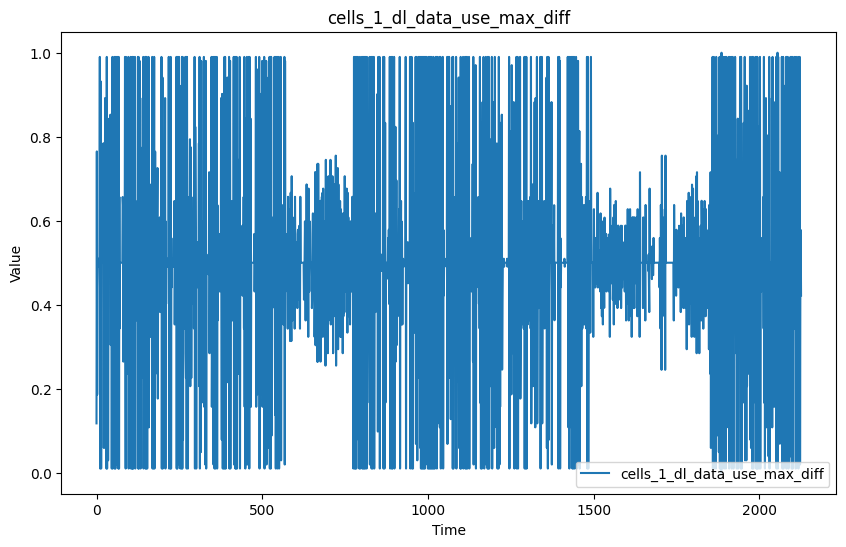

cells_1_dl_use_max_diff


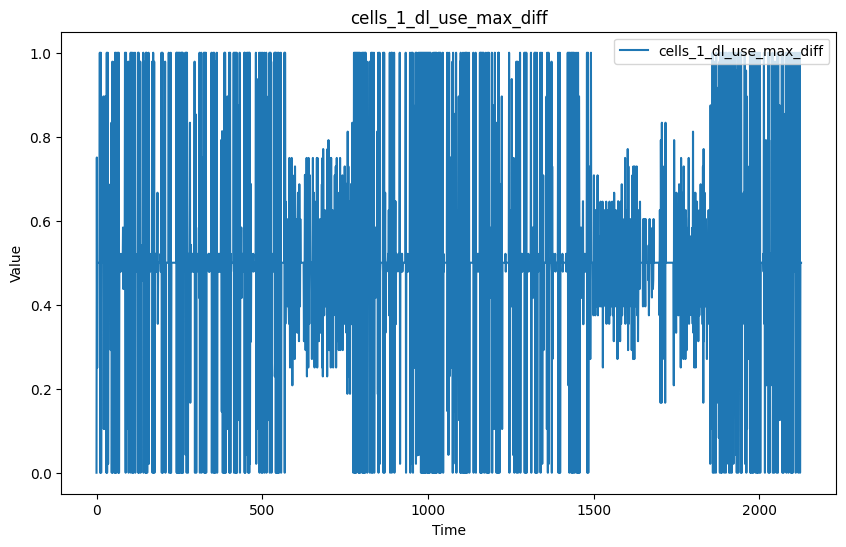

cells_1_ul_bitrate_diff


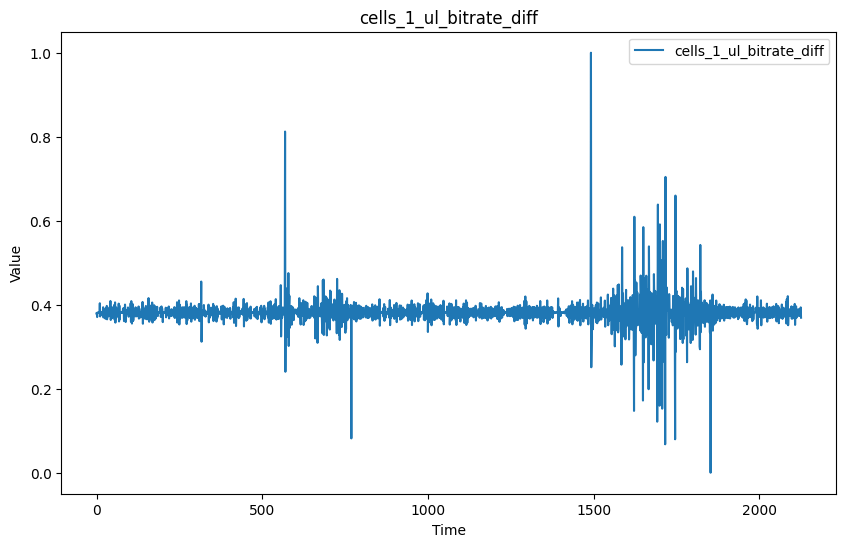

cells_1_ul_data_use_max_diff


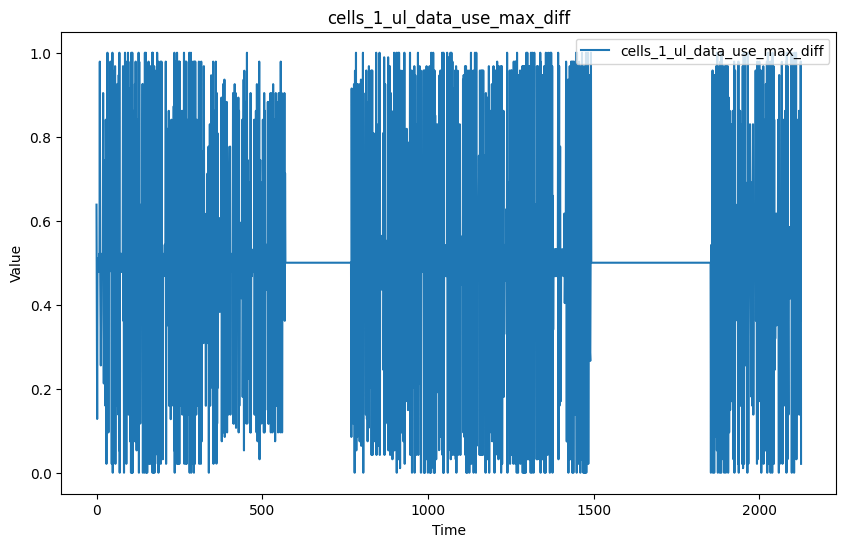

cells_1_ul_use_max_diff


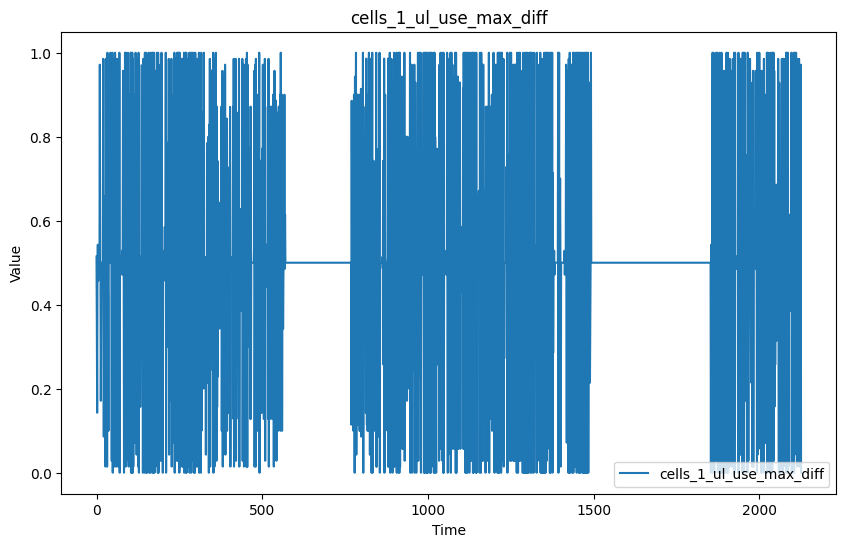

cells_1_ul_use_min_diff


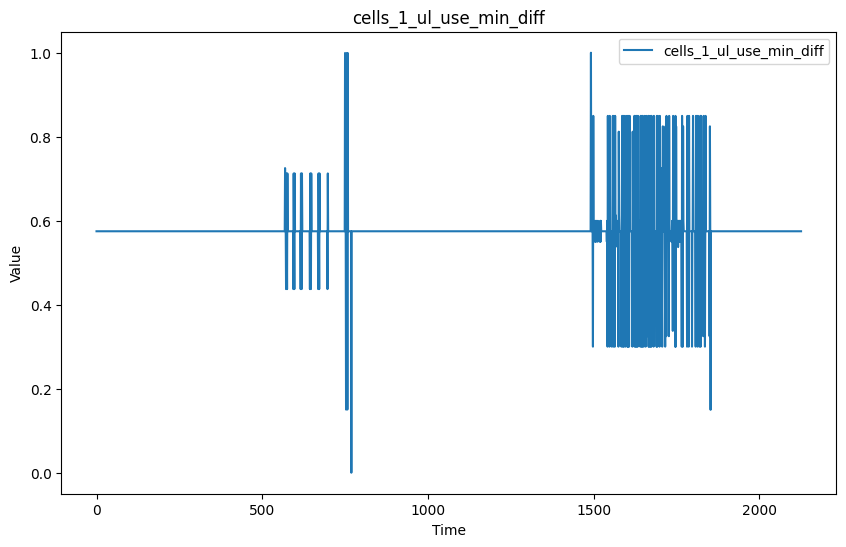

cells_1_ul_sched_users_min_diff


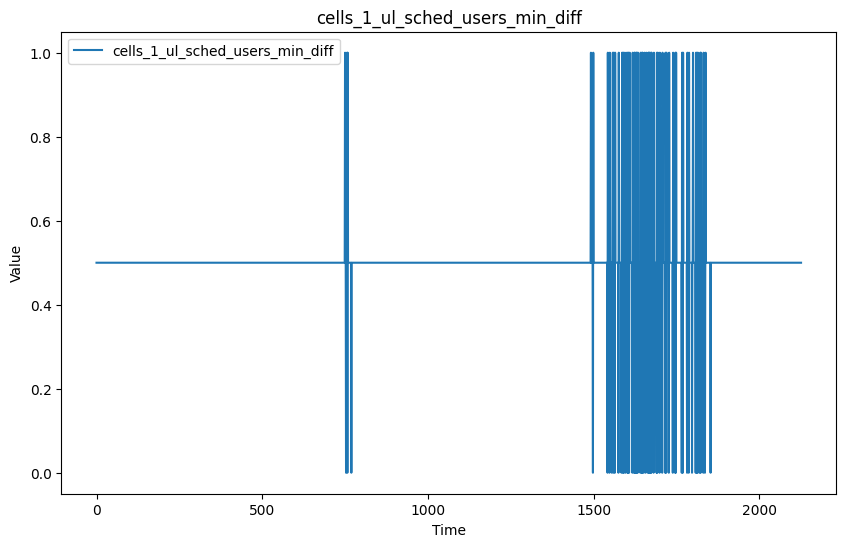

cells_1_ul_retx_diff


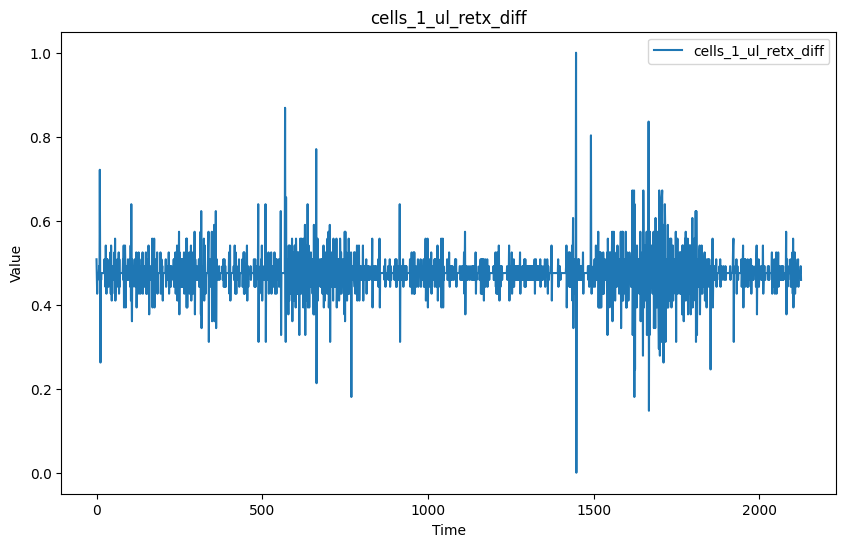

cells_1_ul_data_use_min_diff


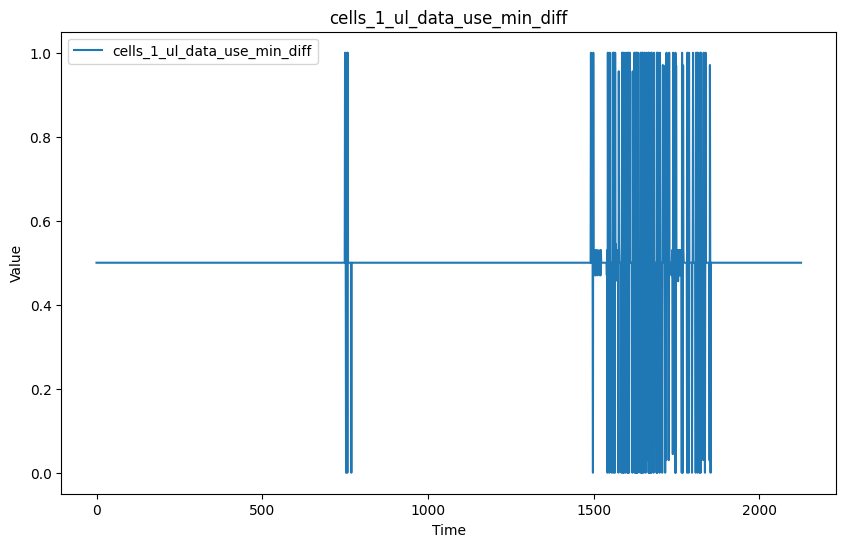

In [22]:
visualize_data(train_df)

In [23]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, silhouette_score


In [24]:

# Define the parameter grid
param_grid_iforest = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 100, 200],
    'contamination': [0.2, 0.25, 0.3]
}

# Initialize the classifier
iforest = IsolationForest(random_state=42)

# Custom scorer - you can change this based on what you need, e.g., f1, roc_auc
scorer = make_scorer(f1_score, greater_is_better=True)

# Initialize the GridSearchCV object with a more suitable scorer
grid_search_iforest = GridSearchCV(estimator=iforest, param_grid=param_grid_iforest, cv=3, scoring=scorer)

# Fit the grid search to the data
grid_search_iforest.fit(train_df)
best_iforest = grid_search_iforest.best_estimator_

# Predict on test data using the best parameters
y_pred_iforest = best_iforest.predict(test_df)
y_pred_iforest = np.where(y_pred_iforest == -1, 1, 0)  # Converting to 1 for anomaly, 0 for normal


In [25]:
# Initialize the best score to a very low number
best_score = -np.inf
best_params = {}

contamination_levels = [0.2, 0.25, 0.3]
n_neighbors_options = [5, 10, 20]

# Assuming you have some labels for validation, even in an unsupervised setting
# If not, you might need to rely on internal metrics like silhouette score or others.
for contamination in contamination_levels:
    for n_neighbors in n_neighbors_options:
        # Create LOF model with current parameters
        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
        
        # Apply LOF
        y_pred_lof = lof.fit_predict(train_df)
        
        # Convert labels to binary anomaly indicators (1 for anomaly, 0 for normal)
        # This assumes '1' in y_pred_lof indicates normal, '-1' indicates anomaly
        binary_preds = (y_pred_lof == -1).astype(int)
        
        # If you have some labeled data for validation, calculate the performance
        if 'true_labels' in train_df.columns:  # Replace 'true_labels' with your actual labels column
            score = f1_score(train_df['true_labels'], binary_preds, pos_label=1)
        else:
            # Calculate silhouette score as an internal metric
            score = silhouette_score(train_df, binary_preds)
        
        # Check if this score is better, and if so, update best parameters
        if score > best_score:
            best_score = score
            best_params = {'contamination': contamination, 'n_neighbors': n_neighbors}

# Apply best parameters found to create the best LOF model
best_lof = LocalOutlierFactor(**best_params)
y_pred_lof = best_lof.fit_predict(test_df)
y_pred_lof = np.where(y_pred_lof == 1, 0, 1)  # Convert to binary classification scheme



In [26]:

# Custom scorer for anomaly detection (adjust depending on your label convention; here we assume -1 for anomalies)
def custom_scorer(y_true, y_pred):
    y_true = np.where(y_true == 0, 1, -1)  # Assuming '0' is normal, converting to '-1' for One-Class SVM
    return f1_score(y_true, y_pred, pos_label=-1)

# Update param_grid
param_grid_ocsvm = {
    'nu': [0.05, 0.1, 0.2],
    'gamma': ['scale', 0.1, 0.01, 0.001]  # Removed 'auto' as it's deprecated in newer sklearn versions
}

# Assuming train_df is already filtered to only include normal data (anomaly == 0)
ocsvm = OneClassSVM(kernel='rbf')

# Set up GridSearchCV with the custom scorer
grid_search_ocsvm = GridSearchCV(estimator=ocsvm, param_grid=param_grid_ocsvm, cv=3, scoring=make_scorer(custom_scorer))
grid_search_ocsvm.fit(train_df)

# Best estimator
best_ocsvm = grid_search_ocsvm.best_estimator_

# Prediction (converting labels for evaluation)
y_pred_ocsvm = best_ocsvm.predict(test_df)
y_pred_ocsvm = np.where(y_pred_ocsvm == 1, 0, 1)  # Mapping predictions back to 0 for normal, 1 for anomaly


In [27]:
y_true = test_data['anomaly']

test_df['anomalies_iforest'] = y_pred_iforest
test_df['anomalies_lof'] = y_pred_lof
test_df['anomalies_ocsvm'] = y_pred_ocsvm
test_df['anomaly'] = y_true

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_anomaly_detection(df, method):
    y_true = df['anomaly']
    y_pred = df[method]
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return accuracy, precision, recall, f1


methods = ['anomalies_iforest', 'anomalies_lof', 'anomalies_ocsvm']

print("Test set:")
for method in methods:
    accuracy, precision, recall, f1 = evaluate_anomaly_detection(test_df, method)
    print(f"{method.capitalize()} based anomaly detection: Accuracy = {accuracy:.2f}, Precision = {precision:.2f}, Recall = {recall:.2f}, F1 Score = {f1:.2f}")

Test set:
Anomalies_iforest based anomaly detection: Accuracy = 0.74, Precision = 0.45, Recall = 0.55, F1 Score = 0.49
Anomalies_lof based anomaly detection: Accuracy = 0.66, Precision = 0.31, Recall = 0.40, F1 Score = 0.35
Anomalies_ocsvm based anomaly detection: Accuracy = 0.80, Precision = 0.70, Recall = 0.25, F1 Score = 0.37
